In [1]:
import altair as alt

import jax
import jax.numpy as jnp

import numpyro
from numpyro import handlers
from numpyro.contrib.hsgp.laplacian import eigenfunctions
from numpyro.contrib.hsgp.spectral_densities import (
    diag_spectral_density_squared_exponential,
)
import numpyro.distributions as dist
from numpyro.examples.datasets import MNIST, load_dataset

jax.config.update("jax_enable_x64", True)

# LIKELIHOOD = Literal["normal", "bernoulli"]
# likelihood: LIKELIHOOD = "normal"

In [2]:
train_init, train_fetch = load_dataset(MNIST, shuffle=False)
test_init, test_fetch = load_dataset(MNIST, split="test", shuffle=False)

In [3]:
num_train, train_idx = train_init()
num_test, test_idx = test_init()

img_tr, y_tr = train_fetch(0, train_idx)
img_test, y_test = test_fetch(0, test_idx)

In [4]:
img = jnp.concatenate([img_tr, img_test], axis=0)
y = jnp.concatenate([y_tr, y_test], axis=0).astype(jnp.int8)
mask = jnp.concatenate([jnp.ones_like(y_tr), jnp.zeros_like(y_test)], axis=0).astype(
    jnp.bool
)
X = img.reshape((img.shape[0], -1))  # [0, 1]-valued observations

In [5]:
@jax.tree_util.register_pytree_node_class
class PPCA:
    def __init__(self, latent_dim: int):
        self.latent_dim = latent_dim

    def model(self, X: jnp.array):
        out_dim = X.shape[1]
        Z = numpyro.sample("Z", dist.Normal(0, 1).expand([X.shape[0], self.latent_dim]))

        beta = numpyro.sample(
            "beta", dist.Normal(0, 1), sample_shape=(self.latent_dim, out_dim)
        )
        f = Z @ beta
        numpyro.sample("obs", dist.BernoulliLogits(f), obs=X)

    def tree_flatten(self):
        children = ()  # arrays / dynamic values
        aux_data = self.latent_dim  # static values
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children, **aux_data)


def hsgp(Z: jax.Array, out_dim: int, ell: float, m: int, prefix: str):
    latent_dim = Z.shape[-1]
    with handlers.scope(prefix=prefix, divider="_"):
        alpha = numpyro.sample("alpha", dist.LogNormal(0, 1))

        length_mean = numpyro.sample("length_mean", dist.Normal(0, 1))
        length_std = numpyro.sample("length_std", dist.LogNormal(0, 1))
        length = numpyro.sample(
            "length",
            dist.LogNormal(length_mean, length_std),
            sample_shape=(out_dim, latent_dim),
        )

        phi = eigenfunctions(x=Z, ell=ell, m=m)
        spd = jnp.sqrt(
            diag_spectral_density_squared_exponential(
                alpha=alpha, length=length, ell=ell, m=m, dim=latent_dim
            )
        )
        beta = numpyro.sample(
            "beta", dist.Normal(0, 1), sample_shape=(phi.shape[-1], out_dim)
        )
    return phi @ (spd * beta)


@jax.tree_util.register_pytree_node_class
class HSGPLVM:
    def __init__(
        self,
        latent_dim: int,
        ell: float,
        m: int,
        num_class: int,
        reconstruction_w: float = 0.5,
    ):
        self.latent_dim = latent_dim
        self.ell = ell
        self.m = m
        self.num_class = num_class
        self.reconstruction_w = reconstruction_w

    def model(self, X: jax.Array, y: jax.Array, mask: jax.Array):
        img_out_dim = X.shape[1]

        Z = numpyro.sample("Z", dist.Normal(0, 1).expand([X.shape[0], self.latent_dim]))

        # reconstruct images
        f_img = hsgp(Z, img_out_dim, self.ell, self.m, prefix="img")
        p = numpyro.deterministic("p_img", jax.scipy.special.expit(f_img))
        with handlers.scale(
            scale=self.reconstruction_w  # TODO how to set this in a principled way?
        ):
            numpyro.sample("obs", dist.BernoulliProbs(p), obs=X)

        # classify images
        f_cls = hsgp(Z, self.num_class, self.ell, self.m, prefix="cls")
        p_cls = numpyro.deterministic("p_cls", jax.nn.softmax(f_cls, axis=-1))
        with handlers.mask(mask=mask):
            numpyro.sample("y", dist.CategoricalProbs(p_cls), obs=y)

    def tree_flatten(self):
        children = ()  # arrays / dynamic values
        aux_data = (self.latent_dim, self.ell, self.m)  # static values
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children, **aux_data)

In [6]:
from jax import random
from optax import linear_onecycle_schedule

from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.elbo import Trace_ELBO
from numpyro.infer.svi import SVI
from numpyro.optim import Adam


def fit_svi(
    seed: int,
    model: callable,
    guide: callable,
    num_steps: int = 1000,
    peak_lr: float = 0.01,
    progress_bar: bool = True,
    use_scheduler: bool = False,
    **model_kwargs,
):
    if use_scheduler:
        lr = linear_onecycle_schedule(num_steps, peak_lr)
    else:
        lr = peak_lr
    svi = SVI(model, guide, Adam(lr), Trace_ELBO())
    return svi.run(
        random.PRNGKey(seed), num_steps, progress_bar=progress_bar, **model_kwargs
    )

In [7]:
import datetime
from os import path
from pathlib import Path
import pickle

from numpyro.infer.initialization import init_to_median

# 2, 6.0, 10 gives really sharp results already, even without vectorized lengthscales
# num_steps = 1000
# lr scheduled
# elbo: 10782577
# with vectorized lengthscales...
# num_steps = 1000
# lr scheduled
# elbo: 10734284
# with vectorized lengthscales and priors
# num steps = 1000
# lr unscheduled
# elbo: 9892971 and still falling...
# plot looks awesome...we're really close
# ...
# num steps = 10_000
# lr scheduled
# elbo: NaN
# same thing happens with 2500 steps and no annealing
# could try bumping precision, not sure if this is spd underflow
# 1750 -- elbo: 9509238
# TODO figure out how to pass starting values to continue from a previous run
# TODO safe jnp.exp
# also Bernoulli logits could be unstable at the edges
# try Bernoulli probs, different log_prob implementation
# m = 10 seems to perform even better
# elbo a good bit better on the gp version, runtime comparable
# m = PPCA(2)
# with soft classifications can get elbo down to at least 9000000
m = HSGPLVM(2, ell=6.0, m=10, num_class=10)
guide = AutoNormal(m.model, init_loc_fn=init_to_median(num_samples=25))

timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
results_dir = Path(path.abspath("")).parent / "results"
if not results_dir.exists():
    results_dir.mkdir()

warm_start = True
save = False
fit = False

if warm_start:
    init_params_f = sorted(list(Path.glob(results_dir, "svi_res_*")))[-1]
    with open(init_params_f, "rb") as f:
        print(f"loading warm start {init_params_f}")
        init_params = pickle.load(f)
else:
    init_params = None

if fit:
    svi_res = fit_svi(
        seed=0,
        model=m.model,
        guide=guide,
        X=X,
        y=y,
        mask=mask,
        use_scheduler=False,
        num_steps=1000,
        peak_lr=0.005,
        init_params=None if init_params is None else init_params.params,
    )
    if save and not bool(jnp.isnan(svi_res.losses[-1])):
        with open(results_dir / f"svi_res_{timestamp}.pkl", "wb") as f:
            print(f"saving {results_dir / f'svi_res_{timestamp}.pkl'}")
            pickle.dump(svi_res, f)
else:
    svi_res = init_params

loading warm start /Users/bcooley/github/numpyro/notebooks/results/svi_res_20240618090628.pkl


In [8]:
from numpyro.infer import Predictive

num_samples = 100
post = Predictive(model=guide, params=svi_res.params, num_samples=num_samples)(
    random.PRNGKey(1), X=X, y=y, mask=mask
)
post_predictive = Predictive(
    model=m.model, guide=guide, params=svi_res.params, num_samples=num_samples
)(random.PRNGKey(1), X=X, y=y, mask=mask)

In [9]:
p = post_predictive["p_img"].mean(axis=0)
p_cls = post_predictive["p_cls"].mean(axis=0)

In [21]:
def log_loss(y_true, y_pred):
    return -jnp.mean((y_true * jnp.log(y_pred) + (1 - y_true) * jnp.log(1 - y_pred)))

In [30]:
y_cls = jnp.argmax(p_cls, axis=-1)
y_cls_tr = y_cls[mask]
y_cls_test = y_cls[~mask]

metrics = {
    "reconstruction_error": log_loss(y_true=X, y_pred=p),
    "train_accuracy": jnp.mean(y_cls_tr == y[mask]),
    "test_accuracy": jnp.mean(y_cls_test == y[~mask]),
}
print(f"reconstruction error: {metrics['reconstruction_error']}")
print(f"train accuracy: {metrics['train_accuracy']}")
print(f"test accuracy: {metrics['test_accuracy']}")

with open(results_dir / f"metrics_{timestamp}.pkl", "wb") as f:
    pickle.dump(metrics, f)

reconstruction error: 0.17878383242525162
train accuracy: 0.7513666749000549
test accuracy: 0.7337999939918518


NameError: name 'timestamp' is not defined

reconstruction error: 0.17878383242525162


train accuracy: 0.7513666749000549
test accuracy: 0.7337999939918518


In [10]:
Z_post = post["Z"]  # plot first set of samples
Z_post_mean = Z_post.mean(axis=0)

In [11]:
import pandas as pd

# Z_post_i = Z_post[0]
df = pd.DataFrame({"z0": Z_post_mean[:, 0], "z1": Z_post_mean[:, 1], "label": y})
df["label"] = df["label"].astype("category")

In [12]:
alt.data_transformers.enable("vegafusion")

n = 20_000
df_plot = df.sample(n)

alt.Chart(df_plot).mark_circle(size=10, opacity=0.25).encode(
    x="z0",
    y="z1",
    color="label",
).properties(width=500, height=500).interactive()

alt.Chart(...)

In [14]:
from numpy.random import default_rng

RNG = default_rng(21146)

36795
[-0.49376233 -1.94015449]


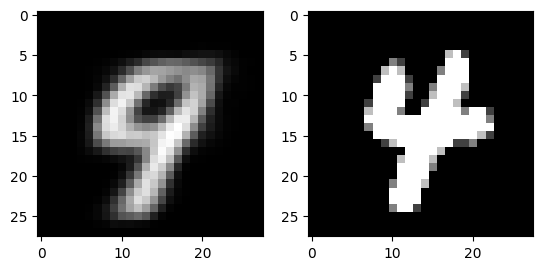

In [26]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sample_idx = RNG.choice(np.arange(num_samples))
value_idx = RNG.choice(np.arange(X.shape[0]))
print(value_idx)

img_sample = p[value_idx].reshape(28, 28)
coords = Z_post_mean[value_idx]
print(coords)
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(img_sample, cmap="gray")

ax2 = fig.add_subplot(122)
ax2.imshow(img_tr[value_idx], cmap="gray")
plt.show()  # TODO plot actual side by side